In [3]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs as scipy_eigs


x,T1,T2,B,alpha, beta = sp.symbols('x T1 T2 B alpha beta')

In [4]:
energies = [0, B, 0]

In [5]:
N = len(energies)

Q1 = sp.Matrix(np.zeros([N,N]))
Q2 = sp.Matrix(np.zeros([N,N]))

def transition_rate(i,j,T):
    return sp.exp(-(energies[j] - energies[i])/T)

def add_transition(Q,i,j,T):
    Q[i,j] += transition_rate(i,j,T)
    Q[i,i] -= transition_rate(i,j,T)
    return Q
    
Q1 = add_transition(Q1,0,1,T1)
Q2 = add_transition(Q2,0,1,T2)
Q1 = add_transition(Q1,-1,-2,T1)
Q2 = add_transition(Q2,-1,-2,T2)

for i in range(1,N-1):
    Q1 = add_transition(Q1,i,i-1,T1)
    Q1 = add_transition(Q1,i,i+1,T1)
    Q2 = add_transition(Q2,i,i-1,T2)
    Q2 = add_transition(Q2,i,i+1,T2)

I = sp.eye(N,N)

Q = beta*sp.kronecker_product(Q1,I) + sp.kronecker_product(I,Q2)

In [6]:
def compute_average_transition_rate(Q1, Q2, energies, T1, T2, beta):
    """
    Compute the average transition rate in equilibrium for the Kronecker sum of Q1 and Q2.
    
    Parameters:
    Q1 (sympy.Matrix): Transition rate matrix for temperature T1.
    Q2 (sympy.Matrix): Transition rate matrix for temperature T2.
    energies (list): List of energy levels.
    T1 (float): Temperature for Q1.
    T2 (float): Temperature for Q2.
    beta (float): Scaling factor for the Kronecker sum.
    
    Returns:
    sympy.Expr: The average transition rate in equilibrium.
    """
    # Number of states
    N = len(energies)

    # Compute the stationary distributions for Q1 and Q2
    pi1 = sp.Matrix([sp.exp(-energies[i] / T1) for i in range(N)])
    pi1 /= sum(pi1)  # Normalize

    pi2 = sp.Matrix([sp.exp(-energies[j] / T2) for j in range(N)])
    pi2 /= sum(pi2)  # Normalize

    # Joint stationary distribution
    pi_joint = sp.Matrix(N, N, lambda i, j: pi1[i] * pi2[j])

    # Construct the combined transition rate matrix Q
    I = sp.eye(N)
    Q_combined = beta * sp.kronecker_product(Q1, I) + sp.kronecker_product(I, Q2)

    # Calculate the average transition rate
    average_rate = sum(pi_joint[i, j] * Q_combined[i * N + j, k * N + l]
                       for i in range(N) for j in range(N)
                       for k in range(N) for l in range(N)
                       if (i, j) != (k, l))

    return average_rate

In [7]:
transition_rate = compute_average_transition_rate(Q1, Q2, energies, T1, T2, beta)

In [8]:
exchange_array = sp.Matrix(np.zeros([N**2,N**2]))
for i in range(N):
    for j in range(N):
        if i != j:
                exchange_array[N*i+j,N*j+i] = sp.Min(1,sp.exp((energies[j]-energies[i])*(1/T2-1/T1)))
                exchange_array[N*i+j,N*i+j] = -sp.Min(1,sp.exp((energies[j]-energies[i])*(1/T2-1/T1)))
E = sp.Matrix(exchange_array)

In [9]:
re_Q = Q + alpha*E

In [10]:
def param_experiment(param_name, param_values, normalize=False):
    params_copy = params.copy()
    del params_copy[param_name]
    Q_subs = Q.subs(params_copy)
    re_Q_subs = re_Q.subs(params_copy)
    transition_rate_subs = transition_rate.subs(params_copy)
    
    func = sp.lambdify(param_name, Q_subs, "numpy")
    re_func = sp.lambdify(param_name, re_Q_subs, "numpy")
    transition_func = sp.lambdify(param_name, transition_rate_subs, 'numpy')
    gammas = []
    re_gammas = []

    for param in param_values:
        transition_rate_eval = transition_func(param)
        Q_eval = func(param)
        eigs = np.linalg.eigvals(-Q_eval)
        gamma = np.sort(eigs)[1]

        if normalize:
            gamma /= transition_rate_eval
        
        gammas.append(gamma)
    
        re_Q_eval = re_func(param)
        re_eigs = np.linalg.eigvals(-re_Q_eval)
        re_gamma = np.sort(re_eigs)[1]

        if normalize:
            re_gamma /= transition_rate_eval
        
        re_gammas.append(re_gamma)
    
    return gammas, re_gammas

In [11]:
params = {B: 3,
          T1: 1,
          T2: 1,
          alpha: 1,
          beta: 1}

/home/lclaeys/miniconda3/envs/discs-env/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/lclaeys/miniconda3/envs/discs-env/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Spectral gap as a function of T1')

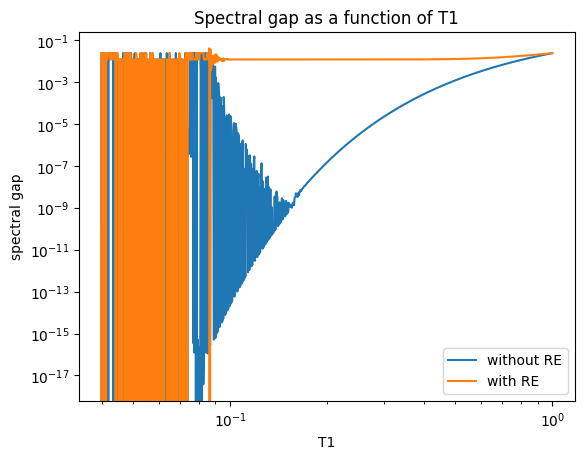

In [12]:
param_name = T1
param_values = np.logspace(-1.4,np.log10(1),1000)

gammas, re_gammas = param_experiment(param_name, param_values, True)

fig, ax = plt.subplots()

ax.plot(param_values,gammas,label='without RE')
ax.plot(param_values,re_gammas,label='with RE')
#ax.plot(param_values,np.exp(-1/param_values),label='exp(-1/T)')

#ax.set_ylim(1e-4,1)
ax.set_xlabel('T1')
ax.set_ylabel('spectral gap')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_title('Spectral gap as a function of T1')

Text(0.5, 1.0, 'Spectral gap as a function of T2')

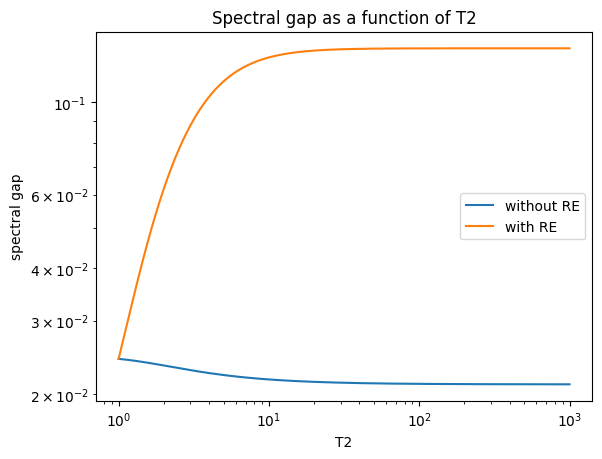

In [13]:
param_name = T2
param_values = np.logspace(0,3,1000)

gammas, re_gammas = param_experiment(param_name, param_values, True)

fig, ax = plt.subplots()

ax.plot(param_values,gammas,label='without RE')
ax.plot(param_values,re_gammas,label='with RE')
#ax.plot(param_values,np.exp(-1/param_values),label='exp(-1/T)')

#ax.set_ylim(1e-4,1)
ax.set_xlabel('T2')
ax.set_ylabel('spectral gap')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_title('Spectral gap as a function of T2')

In [14]:
param_values[np.argmax(re_gammas)]

387.7828414589457

In [15]:
params = {B: 2,
          T1: 1,
          T2: 2,
          alpha: 1,
          beta: 1}

Text(0.5, 1.0, 'Spectral gap as a function of B')

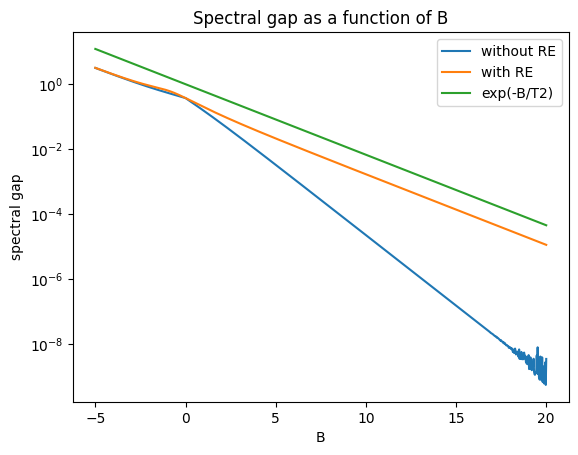

In [16]:
param_name = B
param_values = np.linspace(-5,20,1000)

gammas, re_gammas = param_experiment(param_name, param_values, True)

fig, ax = plt.subplots()

ax.plot(param_values,gammas,label='without RE')
ax.plot(param_values,re_gammas,label='with RE')
#ax.plot(param_values,np.exp(-param_values),label='exp(-B/T1)')
ax.plot(param_values,np.exp(-param_values/params[T2]),label='exp(-B/T2)')

ax.set_xlabel('B')
ax.set_ylabel('spectral gap')
#ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_title('Spectral gap as a function of B')

Text(0.5, 1.0, 'Spectral gap as a function of alpha')

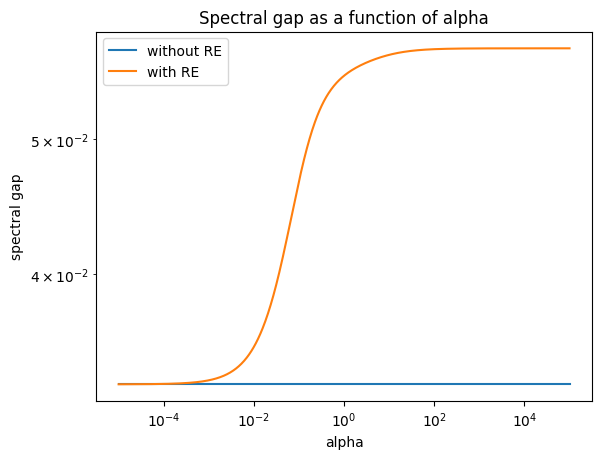

In [22]:
param_name = alpha
param_values = np.logspace(-5,5,1000)

gammas, re_gammas = param_experiment(param_name, param_values, True)

fig, ax = plt.subplots()

ax.plot(param_values,gammas,label='without RE')
ax.plot(param_values,re_gammas,label='with RE')

ax.set_xlabel('alpha')
ax.set_ylabel('spectral gap')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_title('Spectral gap as a function of alpha')

Text(0.5, 1.0, 'Spectral gap as a function of beta')

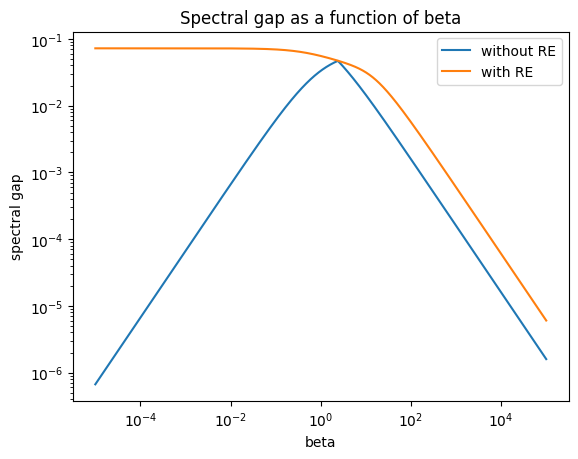

In [23]:
param_name = beta
param_values = np.logspace(-5,5,2000)

gammas, re_gammas = param_experiment(param_name, param_values, True)

fig, ax = plt.subplots()

ax.plot(param_values,gammas,label='without RE')
ax.plot(param_values,re_gammas,label='with RE')

ax.set_xlabel('beta')
ax.set_ylabel('spectral gap')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_title('Spectral gap as a function of beta')

In [156]:
np.log(param_values[np.argmax(gammas)])

3.207377784613267

In [17]:
np.exp(10)

22026.465794806718